### Frequency of the advisor's suggestion being the same as the k-th true best suggestion
Counts how often the advisor's sampled suggestion is the true best, 2nd best, ..., 16th best suggestion. Repeated over a large number of random landscapes.

In [2]:
from common import Advisor, set_matplotlib_latex, plot_colours, all_high_level_suggestions, all_low_level_suggestions, generate_random_landscape, set_axes_length
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
set_matplotlib_latex()
from matplotlib.ticker import FixedLocator, MultipleLocator

In [2]:
def generate_random_landscapes(nr_landscapes):
    # generate random landscapes and initialise the scaled rewards
    random_landscapes = []
    for _ in tqdm(range(nr_landscapes)):
        random_landscape = generate_random_landscape()
        random_landscape.init_scaled_rewards()
        random_landscapes.append(random_landscape)
    return random_landscapes

In [3]:
def suggestion_order_frequency(landscapes, nr_trials, advisor_type):
    """
    Returns a dictionary where the keys are 1, 2, ..., 16 (corresponding to the true order of the suggestions' value) and the values are lists of the frequency of the advisor's suggestion being the same as the k-th true best suggestion (in percentage) after 0, 1, ..., 19 selections.
    
    key 1 -> the frequency of the advisor's suggestion being the same as the true best suggestion after 0, ..., 19 selections
    ...
    key 16 -> the frequency of the advisor's suggestion being the same as the true worst suggestion after 0, ..., 19 selections
    
    advisor_type is either "high" or "low".
    """
    orders_frequencies = {}
    for order in range(1, 17):
        orders_frequencies[order] = []
    for landscape in tqdm(landscapes):
        round_frequencies = {}
        for order in range(1, 17):
            round_frequencies[order] = []
        all_combinations = landscape.get_combinations()
        advisor = Advisor(landscape.get_block_nr1(), landscape.get_block_nr2())
        all_suggestions = all_high_level_suggestions() if advisor_type == "high" else all_low_level_suggestions(landscape.get_block_nr1(), landscape.get_block_nr2())
        all_suggestions.sort(key=lambda suggestion: landscape.suggestion_value(suggestion), reverse=True)
        for _ in range(nr_trials):
            softmax_suggestion = advisor.best_suggestion_high_level(all_combinations) if advisor_type == "high" else advisor.best_suggestion_low_level(all_combinations)
            for order in range(1, 17):
                if all_suggestions[order - 1] == softmax_suggestion:
                    round_frequencies[order].append(1)
                else:
                    round_frequencies[order].append(0)
            # give a new random selection to the advisor
            random_combination = all_combinations[np.random.randint(low=0, high=len(all_combinations))]
            random_selection = landscape.selection_with_noisy_reward(random_combination)
            advisor.update_with_selection(random_selection)
        for order in range(1, 17):
            orders_frequencies[order].append(round_frequencies[order])
    for order in range(1, 17):
        orders_frequencies[order] = 100 * np.mean(orders_frequencies[order], axis=0)
    return orders_frequencies

def save_and_plot_performance(filename_figure_high_low, filename_figure_average, filename_simulation_high, filename_simulation_low, frequency_high, frequency_low, show=True):
    plot_width = 1.05
    plot_height = 0.7
    order_numbers = list(range(1, 17))
    overall_frequency_high = []
    overall_frequency_low = []
    for order in range(1, 17):
        overall_frequency_high.append(np.mean(frequency_high[order]))
        overall_frequency_low.append(np.mean(frequency_low[order]))
    overall_frequency_average = [(overall_frequency_low[i] + overall_frequency_high[i]) / 2 for i in range(16)]
    print(f"suggestion order frequencies (global): {overall_frequency_high}")
    print(f"suggestion order frequencies (local): {overall_frequency_low}")
    print(f"suggestion order frequencies (average): {overall_frequency_average}")
    plt.plot(order_numbers, overall_frequency_high, label="Global", color=plot_colours["global"])
    plt.plot(order_numbers, overall_frequency_low, label="Local", color=plot_colours["local"])
    plt.legend(loc="upper right")
    plt.xlabel("Suggestion order")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 6, 11, 16]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=20))
    plt.ylabel("Frequency (\%)")
    set_axes_length(plot_width, plot_height)
    plt.savefig(filename_figure_high_low, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
    plt.plot(order_numbers, overall_frequency_average, color=plot_colours["ai"])
    plt.xlabel("Suggestion order")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 6, 11, 16]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=20))
    plt.ylabel("Frequency (\%)")
    set_axes_length(plot_width, plot_height)
    plt.savefig(filename_figure_average, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
    with open(filename_simulation_high, "w") as file_high:
        for order in range(1, 17):
            file_high.write(f"{order}\n")
            for frequency in frequency_high[order]:
                file_high.write(f"{frequency}\n")
            file_high.write("\n")
    with open(filename_simulation_low, "w") as file_low:
        for order in range(1, 17):
            file_low.write(f"{order}\n")
            for frequency in frequency_low[order]:
                file_low.write(f"{frequency}\n")
            file_low.write("\n")

100%|██████████| 100000/100000 [6:10:34<00:00,  4.50it/s] 


suggestion order frequencies (global): [60.91015, 8.66085, 7.5518, 4.7056000000000004, 3.45405, 2.57425, 2.0709, 1.8581999999999994, 1.66175, 1.4927, 1.2535000000000003, 0.9801, 0.8398, 0.75005, 0.7152999999999999, 0.521]
suggestion order frequencies (local): [56.661000000000016, 13.5952, 6.761799999999999, 4.40025, 3.4318999999999997, 2.7952, 2.2962000000000007, 1.8734999999999995, 1.6738000000000004, 1.3563000000000003, 1.19485, 1.04135, 0.92165, 0.76945, 0.6709499999999999, 0.5566]
suggestion order frequencies (average): [58.78557500000001, 11.128025000000001, 7.1568, 4.552925, 3.4429749999999997, 2.6847250000000003, 2.1835500000000003, 1.8658499999999996, 1.6677750000000002, 1.4245, 1.2241750000000002, 1.0107249999999999, 0.880725, 0.7597499999999999, 0.693125, 0.5388]


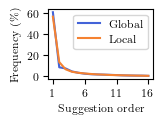

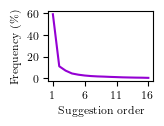

In [5]:
%matplotlib inline

nr_trials = 20
nr_landscapes = 100000

landscapes = generate_random_landscapes(nr_landscapes)
frequency_high = suggestion_order_frequency(landscapes, nr_trials, "high")
frequency_low = suggestion_order_frequency(landscapes, nr_trials, "low")
filename_figure_high_low = f"../figures/advisor_suggestion_order/suggestion_order_high_low.pdf"
filename_figure_average = f"../figures/advisor_suggestion_order/suggestion_order_average.pdf"
filename_simulation_high = f"../outputs/advisor_suggestion_order/suggestion_order_high.txt"
filename_simulation_low = f"../outputs/advisor_suggestion_order/suggestion_order_low.txt"
save_and_plot_performance(filename_figure_high_low, filename_figure_average, filename_simulation_high, filename_simulation_low, frequency_high, frequency_low)